In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

## Load Dataset

In [2]:
download_root = './MNIST_DATASET'

In [3]:
# Normalize data with mean=0.1307, std=0.3081
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [4]:
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

## Data Loader

In [14]:
batch_size = 20

In [15]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.3
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.shuffle(indices)
    
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                          sampler=train_sampler)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=batch_size,
                          sampler=valid_sampler)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

In [17]:
num_train = len(train_loader) * batch_size
num_valid = len(valid_loader) * batch_size
num_test = len(test_loader) * batch_size
num_train, num_valid, num_test

(42000, 18000, 10000)

## Define a model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*64, 1024)
        self.fc2 = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5*5*64)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [7]:
model = CNN()

In [8]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("we are using GPU!")
    model = model.cuda()

we are using GPU!


## Define Optimizer

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Define Criterion 

In [19]:
criterion = nn.CrossEntropyLoss()

In [21]:
save_path = "./MNIST_MODELS"

In [ ]:
model.train()
best_loss = 9999.0

for epoch in range(20):
    avg_loss = 0
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        output = model(x)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))
            
    model.eval()
    
    valid_loss=0
    valid_correct=0
    
    for batch_idx, (x, target) in enumerate(valid_loader):
        bb+=1
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        output = model(x)
        valid_loss += criterion(output, target).item() # sum up batch loss
        
    valid_loss /= batch_idx
    print("[validation] valid_loss: {:.3f}".format(valid_loss))
    if valid_loss < best_loss:
        print("[validation] saving models {}".format(valid_loss))
        torch.save(model.state_dict(), save_path)
        best_loss = valid_loss

## Load Saved Models

In [12]:
model.load_state_dict(torch.load(save_path))

## Test Models

In [22]:
model.eval()

test_loss = 0
correct = 0
with torch.no_grad():
    for x, target in test_loader:
        if use_cuda:
            x, target = x.cuda(), target.cuda()
            output = model(x)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= num_test

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / num_test))


Test set: Average loss: 0.0014, Accuracy: 9910/10000 (99%)



In [24]:
!pip install matplotlib

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
x, target = next(iter(test_loader))

In [39]:
x.shape, target.shape

(torch.Size([20, 1, 28, 28]), torch.Size([20]))

In [41]:
target[:10]

tensor([0, 1, 9, 0, 3, 3, 7, 4, 0, 6])

In [52]:
def imshow(x, target):
    pixels = x.reshape(28, 28)
    plt.title('Label: {}'.format(target))
    plt.imshow(pixels, cmap='gray')
    plt.show()

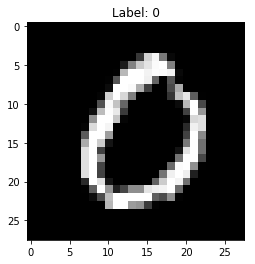

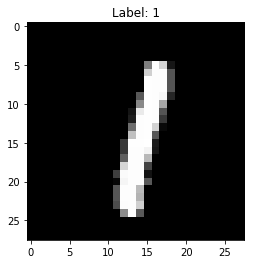

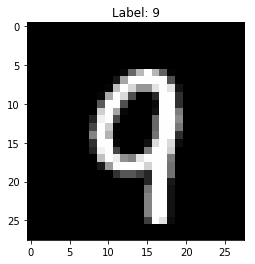

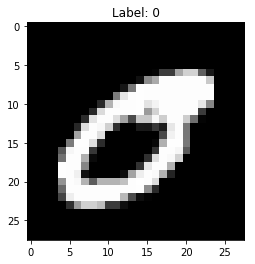

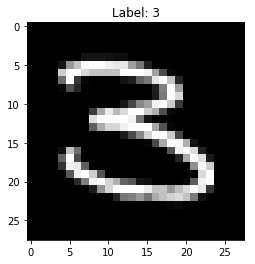

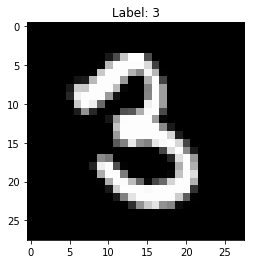

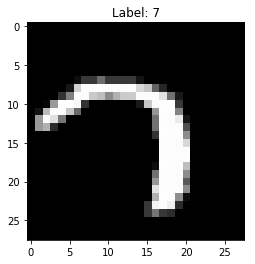

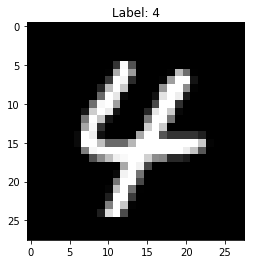

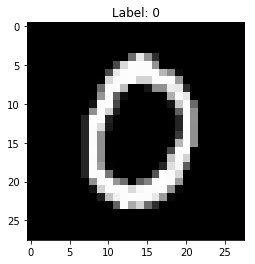

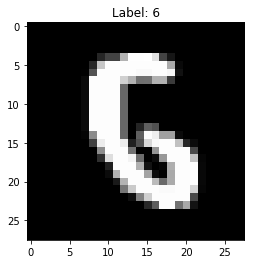

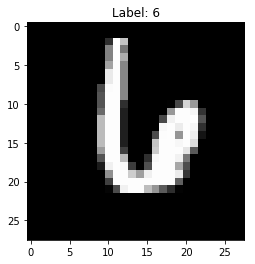

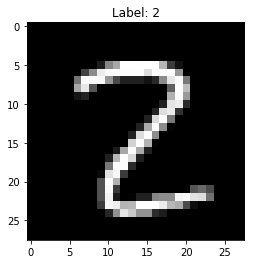

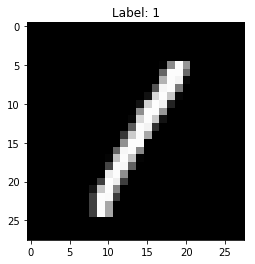

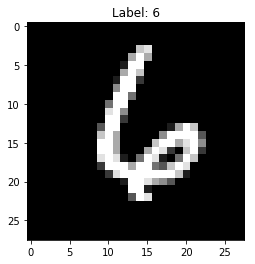

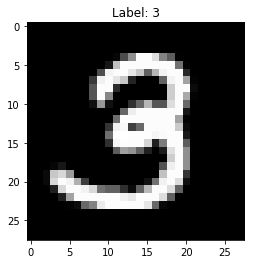

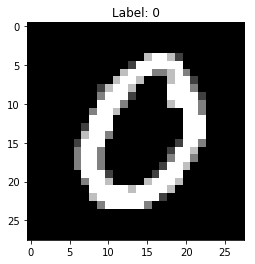

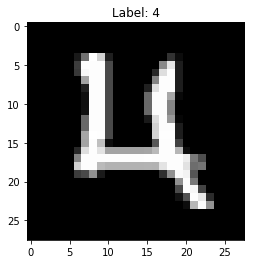

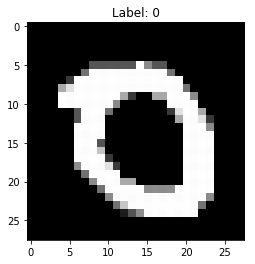

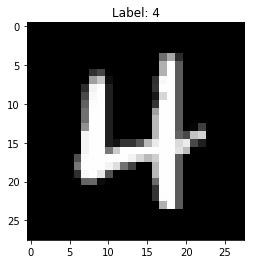

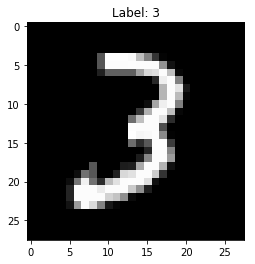

In [54]:
for i in range(20):
    imshow(x[i], target[i])